In [1]:
import scipy.io as sci
import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt

### Separate based on response (flash first or beep first)

In [2]:
resppath = 'StabilityofPCommonData/NumerosityTaskUnformatted/*.mat'
respfiles = np.array(glob.glob(resppath))
datapath = 'StabilityofPCommonData/NumerosityTaskData/*.mat'
datafiles = np.array(glob.glob(datapath))

In [3]:
# filenames for f or b responses
respf = np.empty((1, 1))
respb = np.empty((1, 1))
for names in respfiles:
    mat = sci.loadmat(names)
    resp = mat['respCode']
    if(resp == "f"):
        respf = np.append(respf, names)
    else:
        respb = np.append(respb, names)
respf = respf[1:]
respb = respb[1:]

In [4]:
# index for flash first files(1 if yes 0 if no) 
# use for TaskData to pull data for subjects that reported flash first
indexf = list()
c = 0
for x in respfiles:
    if x in respf:
        indexf.append(c)
    c += 1
#respfiles[indexf]

# exclude files that are incomplete
dataf = datafiles[indexf]
missing = np.empty((1,1), dtype = int)

for i in np.arange(0, len(dataf)):
    mat = sci.loadmat(dataf[i])
    #print(len(mat['trialData']))
    if len(mat['trialData']) < 360:
        missing = np.append(missing, i)
        #print(len(mat['trialData']), i)
missing = missing[1:]
indexf = np.delete(indexf, missing)

### Extract trial data and response times for flash trials

In [5]:
# further subset into flash reported and insert indices for subject id  
dataf = datafiles[indexf]

subjidf = np.array([2,5,7,7,11,11,12,12,15,15,19,20,20,23,28,31,32,32,35,36,37,37,40,
                   40,41,41,42,50,50,53,53,54,54,57,57,60,60,61,61,64])
trialsf = np.empty((1,5))
for i in np.arange(0, len(dataf)):
    mat = sci.loadmat(dataf[i])
    arr = mat['trialData']
    # add subject id to the first column
    arr = np.insert(arr, 0, int(subjidf[i]), axis=1)
    trialsf = np.vstack((trialsf, arr))
trialsf = trialsf[1:]
print(len(trialsf))

# add a response column to second column, 1 if correct 0 if wrong
respcol = np.empty((1,1))
for rows in trialsf:
    if rows[1] == rows[3]:
        respcol = np.append(respcol, 1)
    else:
        respcol = np.append(respcol, 0)
respcol = respcol[1:]

trialsf = np.insert(trialsf, 1, respcol, axis=1)
print(trialsf)

14400
[[ 2.  1.  0.  3.  0.  3.]
 [ 2.  1.  0.  3.  0.  2.]
 [ 2.  1.  1.  1.  1.  1.]
 ...
 [64.  1.  3.  4.  3.  3.]
 [64.  0.  4.  0.  3.  0.]
 [64.  0.  1.  4.  3.  3.]]


In [6]:
# extract response times from taskunformatted and merge with trialdata
resptimes = np.empty((1,1))

# only include files that correspond to complete trialData
respf = respfiles[indexf]

for i in np.arange(0, len(respf)):
    mat = sci.loadmat(respf[i])
    arr = mat['resptime']
    resptimes = np.append(resptimes, arr)
resptimes = resptimes[1:]
print(len(resptimes))

trialsf = np.insert(trialsf, 1, resptimes, axis = 1)
print(trialsf[1])

14400
[2.         0.64134615 1.         0.         3.         0.
 2.        ]


### Further subset into congruent, incongruent, and unimodal rows

In [7]:
# congruent 
congf = np.empty((1,7))
incongf = np.empty((1,7))
unif = np.empty((1,7))

# store indices of rows for congruent, incongruent, and unisensory for extracting resptimes
congindf = np.empty((1,1), dtype = int)
incongindf = np.empty((1,1), dtype = int)
uniindf = np.empty((1,1), dtype = int)

for i in np.arange(0, len(trialsf)):
    # only consider rows where flashes are presented
    if trialsf[i][3] != 0:
        # unisensory(beeps presented are 0)
        if trialsf[i][4] == 0:
            unif = np.vstack((unif, trialsf[i]))
            uniindf = np.append(uniindf, i)
        # if congruent between flash and beeps presented
        if trialsf[i][3] == trialsf[i][4]:
            congf = np.vstack((congf, trialsf[i]))
            congindf = np.append(congindf, i)
        else:
            incongf = np.vstack((incongf, trialsf[i]))
            incongindf = np.append(incongindf, i)
congf = congf[1:]
incongf = incongf[1:]
unif = unif[1:]
congindf = congindf[1:]
incongindf = incongindf[1:]
uniindf = uniindf[1:]
print(congf)

[[2.00000000e+00 4.53016628e-01 1.00000000e+00 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]
 [2.00000000e+00 8.11536271e-01 1.00000000e+00 ... 1.00000000e+00
  1.00000000e+00 2.00000000e+00]
 [2.00000000e+00 2.50152766e-01 1.00000000e+00 ... 3.00000000e+00
  3.00000000e+00 2.00000000e+00]
 ...
 [6.40000000e+01 6.25321059e+00 1.00000000e+00 ... 3.00000000e+00
  3.00000000e+00 2.00000000e+00]
 [6.40000000e+01 5.51931980e-02 1.00000000e+00 ... 2.00000000e+00
  2.00000000e+00 2.00000000e+00]
 [6.40000000e+01 5.19106439e+00 0.00000000e+00 ... 1.00000000e+00
  3.00000000e+00 1.00000000e+00]]


In [395]:
# attach resptimes to trialdata
congf = np.insert(congf, 1, resptimes[congindf], axis = 1)
incongf = np.insert(incongf, 1, resptimes[incongindf], axis = 1)
unif = np.insert(unif, 1, resptimes[uniindf], axis = 1)

In [10]:
congfdata = pd.DataFrame(congf, columns=['Subj_id', 'rt', 'response', 'flashpres', 'beeppres', 'flashrep', 'beeprep'])
incongfdata = pd.DataFrame(incongf, columns=['Subj_id', 'rt', 'response', 'flashpres', 'beeppres', 'flashrep', 'beeprep'])
unifdata = pd.DataFrame(unif, columns=['Subj_id', 'rt', 'response', 'flashpres', 'beeppres', 'flashrep', 'beeprep'])

##### The formatting for the data to be inputed is as follows:
Column 1: Subject ID <br>
Column 2: Response Time <br>
Column 3: Response  <br>
Column 4: Flashes presented <br>
Column 5: Beeps presented <br>
Column 6: Flashes reported <br>
Column 7: Beeps reported <br>

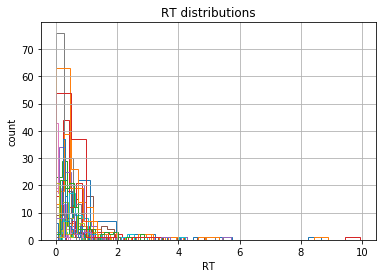

### Repeat for beep trials

In [307]:
# index for flash first files(1 if yes 0 if no) 
# use for TaskData to pull data for subjects that reported flash first
indexb = list()
c = 0
for x in respfiles:
    if x in respb:
        indexb.append(c)
    c += 1
#respfiles[indexf]

# exclude files that are incomplete
datab = datafiles[indexb]
missing = np.empty((1,1), dtype = int)

for i in np.arange(0, len(datab)):
    mat = sci.loadmat(datab[i])
    #print(len(mat['trialData']))
    if len(mat['trialData']) < 360:
        missing = np.append(missing, i)
        #print(len(mat['trialData']), i)
missing = missing[1:]
indexb = np.delete(indexb, missing)

In [331]:
datab = datafiles[indexb]
subjidb = np.array([6,6,9,10,10,13,14,14,16,16,21,21,22,25,25,26,26,
                    29,30,30,34,36,39,39,42,44,44,47,47,48,48,51,51,59,59,62,62,63,63,64])
trialsb = np.empty((1,5))
for i in np.arange(0, len(datab)):
    mat = sci.loadmat(datab[i])
    arr = mat['trialData']
    # add subject id to the first column
    arr = np.insert(arr, 0, int(subjidb[i]), axis=1)
    trialsb = np.vstack((trialsb, arr))
trialsb = trialsb[1:]
print(len(trialsb))

# add a response column to second column, 1 if correct 0 if wrong
respcol = np.empty((1,1))
for rows in trialsb:
    if rows[1] == rows[3]:
        respcol = np.append(respcol, 1)
    else:
        respcol = np.append(respcol, 0)
respcol = respcol[1:]

trialsb = np.insert(trialsb, 1, respcol, axis=1)
print(trialsb)

14400
[[ 6.  1.  0.  3.  0.  3.]
 [ 6.  1.  0.  3.  0.  3.]
 [ 6.  1.  1.  1.  1.  1.]
 ...
 [64.  1.  2.  0.  2.  0.]
 [64.  0.  4.  3.  3.  3.]
 [64.  0.  1.  4.  2.  3.]]


In [332]:
# extract response times from taskunformatted and merge with trialdata
resptimes = np.empty((1,1))

# only include files that correspond to complete trialData
respb = respfiles[indexb]

for i in np.arange(0, len(respb)):
    mat = sci.loadmat(respb[i])
    arr = mat['resptime']
    resptimes = np.append(resptimes, arr)
resptimes = resptimes[1:]
print(resptimes)

[1.0934389  0.43513205 0.31148193 ... 0.98392507 2.03043482 1.05056333]


In [337]:
# congruent 
congb = np.empty((1,6))
incongb = np.empty((1,6))
unib = np.empty((1,6))

# store indices of rows for congruent, incongruent, and unisensory for extracting resptimes
congindb = np.empty((1,1), dtype = int)
incongindb = np.empty((1,1), dtype = int)
uniindb = np.empty((1,1), dtype = int)

for i in np.arange(0, len(trialsb)):
    # only consider rows where flashes are presented
    if trialsb[i][1] != 0:
        # unisensory(beeps presented are 0)
        if trialsb[i][2] == 0:
            unib = np.vstack((unib, trialsb[i]))
            uniindb = np.append(uniindb, i)
        # if congruent between flash and beeps presented
        if trialsb[i][1] == trialsb[i][2]:
            congb = np.vstack((congb, trialsb[i]))
            congindb = np.append(congindb, i)
        else:
            incongb = np.vstack((incongb, trialsb[i]))
            incongindb = np.append(incongindb, i)
congb = congb[1:]
incongb = incongb[1:]
unib = unib[1:]
congindb = congindb[1:]
incongindb = incongindb[1:]
uniindb = uniindb[1:]

In [338]:
# attach resptimes to trialdata
congb = np.insert(congb, 1, resptimes[congindb], axis = 1)
incongb = np.insert(incongb, 1, resptimes[incongindb], axis = 1)
unib = np.insert(unib, 1, resptimes[uniindb], axis = 1)

In [ ]:
congbdata = pd.DataFrame(congb, columns=['Subj_id', 'rt', 'response', 'flashpres', 'beeppres', 'flashrep', 'beeprep'])
incongbdata = pd.DataFrame(incongb, columns=['Subj_id', 'rt', 'response', 'flashpres', 'beeppres', 'flashrep', 'beeprep'])
unibdata = pd.DataFrame(unib, columns=['Subj_id', 'rt', 'response', 'flashpres', 'beeppres', 'flashrep', 'beeprep'])

### Plot response times for both 

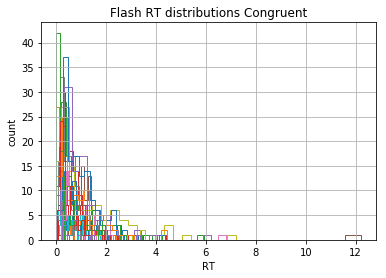

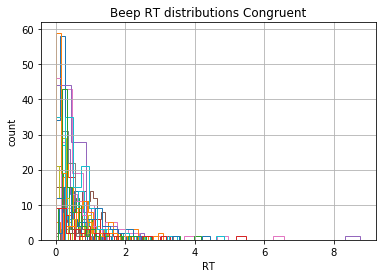

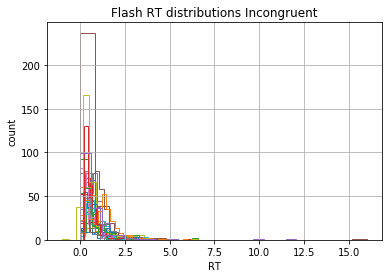

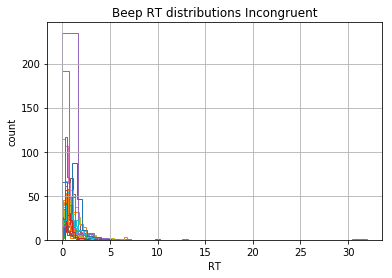

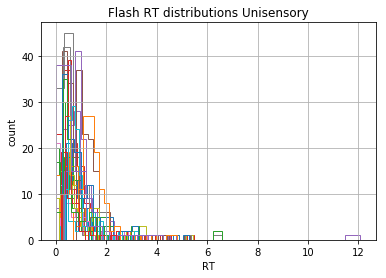

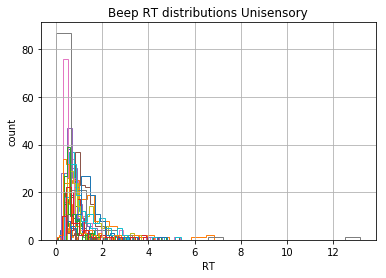

In [364]:
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='Flash RT distributions Congruent')
for i, subj_data in congfdata.groupby('Subj_id'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='Beep RT distributions Congruent')
for i, subj_data in congbdata.groupby('Subj_id'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)
    
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='Flash RT distributions Incongruent')
for i, subj_data in incongfdata.groupby('Subj_id'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='Beep RT distributions Incongruent')
for i, subj_data in incongbdata.groupby('Subj_id'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)
    
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='Flash RT distributions Unisensory')
for i, subj_data in unifdata.groupby('Subj_id'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='Beep RT distributions Unisensory')
for i, subj_data in unibdata.groupby('Subj_id'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

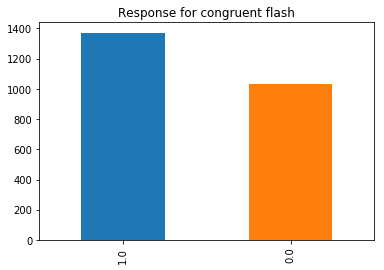

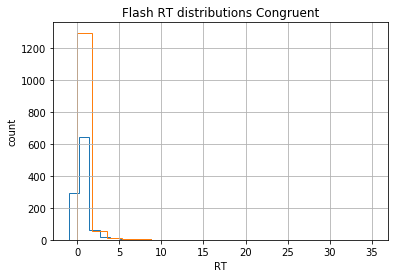

In [25]:
congfdata['response'].value_counts().plot(kind='bar')
plt.title("Response for congruent flash")

fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='Flash RT distributions Congruent')
for i, subj_data in congfdata.groupby('response'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

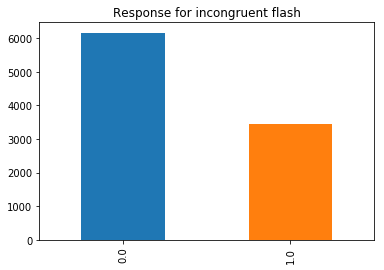

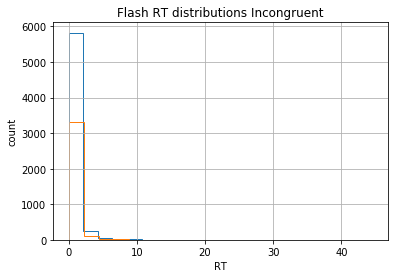

In [26]:
incongfdata['response'].value_counts().plot(kind='bar')
plt.title("Response for incongruent flash")

fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='Flash RT distributions Incongruent')
for i, subj_data in incongfdata.groupby('response'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

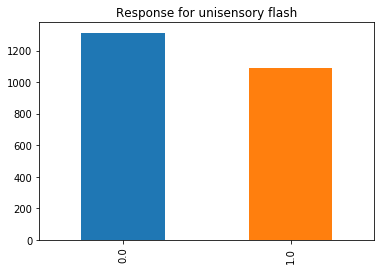

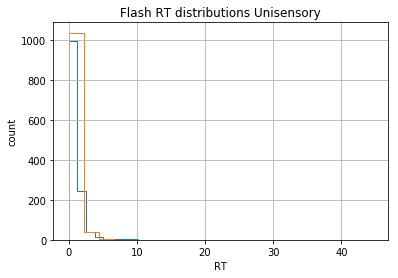

In [27]:
unifdata['response'].value_counts().plot(kind='bar')
plt.title("Response for unisensory flash")

fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='Flash RT distributions Unisensory')
for i, subj_data in unifdata.groupby('response'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)